In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models.dmds import DMDSGatedCNN
from nebula.models import TransformerEncoderChunks, Cnn1DLinear
from nebula.models.attention_v2 import TransformerEncoderModelCls, CharTransformer
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis", "dmds"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
SEQ_LEN = 512
LIMIT = "full"

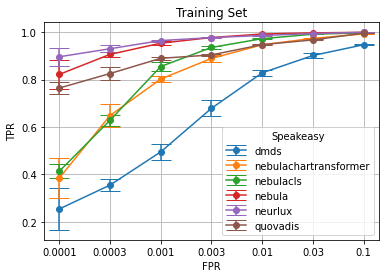

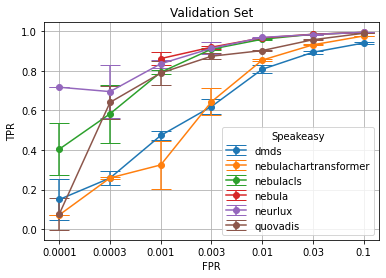

In [2]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0:1]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
models = defaultdict(dict)

nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")
neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")

quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_600_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 1, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}

models['dmds']['class'] = DMDSGatedCNN
models['dmds']['config'] = {
    "ndim": 98,
    "seq_len": SEQ_LEN,
}

models['nebulacls']['class'] = TransformerEncoderModelCls
models['nebulacls']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 1, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "norm_first": True
}

# models['nebulacnn1dlinear']['class'] = Cnn1DLinear
# models['nebulacnn1dlinear']['config'] = {
#     "vocab_size": len(nebula_vocab),
#     "maxlen": SEQ_LEN,
#     "embeddingDim": 96,
#     "hiddenNeurons": [512, 256, 128],
#     "batchNormConv": False,
#     "batchNormFFNN": False,
#     "filterSizes": [2, 3, 4, 5],
#     "dropout": 0.3
# }

models['nebulachartransformer']['class'] = CharTransformer
models['nebulachartransformer']['config'] = {
    "patch_size": 16,
    "in_chans": 1,
    "embed_dim": 128,
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "hiddenNeurons": [512, 256, 128],
    "transformer_layers": 4,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_files = defaultdict(list)
metrics_val = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
        print(f"[!] Loaded: {key}")
    else:
        metrics = []
        print(f"[!] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        print(f"[*] Reading data splits from: {folder}")
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[!] Loaded: dmds
[!] Loaded: nebulachartransformer
[!] Loaded: nebulacls
[!] Loaded: nebula
[!] Loaded: neurlux
[!] Loaded: quovadis


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
dmds,0.153990,0.270200,0.476728,0.619717,0.808046,0.894922,0.942644,0.991815,0.982715,0.941078,0.906657,0.978361,0.923324
nebulachartransformer,0.041260,0.183926,0.326107,0.644119,0.854385,0.931666,0.976347,0.994714,0.988908,0.965962,0.961714,0.970260,0.954194
nebulacls,0.421859,0.489303,0.682914,0.833301,0.932799,0.979827,0.993470,0.998678,0.996150,0.980827,0.972211,0.989636,0.974319
nebula,0.235009,0.543692,0.851965,0.926304,0.966533,0.984413,0.994422,0.999125,0.997423,0.984811,0.982935,0.986698,0.979508
neurlux,0.537603,0.699828,0.836229,0.914644,0.968982,0.984257,0.994913,0.999242,0.997595,0.984755,0.979768,0.989805,0.979495
quovadis,0.078150,0.650227,0.789196,0.874130,0.924370,0.959923,0.991590,0.998950,0.995422,0.970978,0.954386,0.988188,0.961445


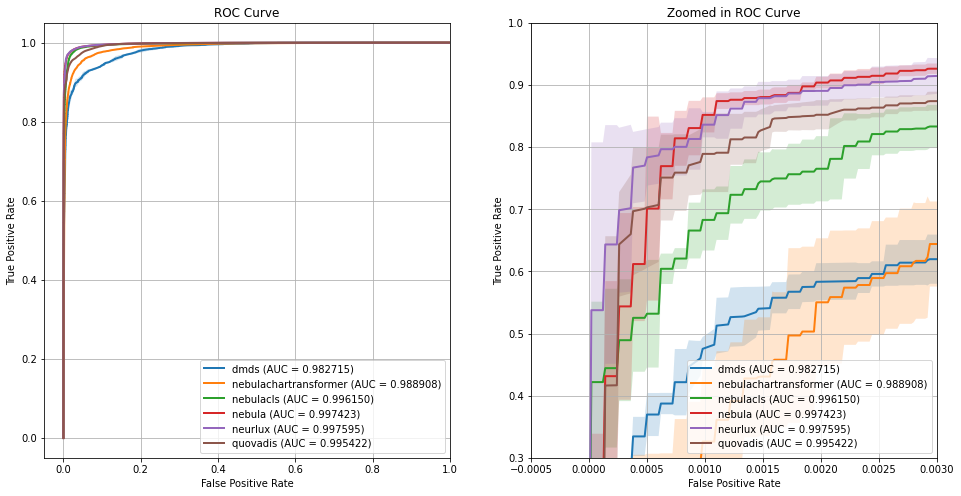

In [5]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [7]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        try:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        except IndexError:
            if key.startswith("nebula"):
                data_folder = [x for x in os.listdir(INFOLDER) if x.startswith("nebula") and "vocab" in x][0]
            else:
                data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and not x.endswith(".pkl")][0]
        print(f"[*] Reading data splits from: {data_folder}")
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

[*] In process: nebulachartransformer
[*] Reading data splits from: nebula_speakeasy_vocab_50000_seqlen_512
[*] Running ROC for split: 0
Evaluating nebulachartransformer_split_0 | Size: 890753...


100%|██████████| 182/182 [00:02<00:00, 66.13it/s] 


[*] Running ROC for split: 1
Evaluating nebulachartransformer_split_1 | Size: 890753...


100%|██████████| 182/182 [00:01<00:00, 168.84it/s]


[*] Running ROC for split: 2
Evaluating nebulachartransformer_split_2 | Size: 890753...


100%|██████████| 182/182 [00:01<00:00, 167.34it/s]


[*] In process: nebulacls
[*] Reading data splits from: nebula_speakeasy_vocab_50000_seqlen_512
[*] Running ROC for split: 0
Evaluating nebulacls_split_0 | Size: 3304321...


100%|██████████| 182/182 [00:14<00:00, 12.50it/s]


[*] Running ROC for split: 1
Evaluating nebulacls_split_1 | Size: 3304321...


100%|██████████| 182/182 [00:14<00:00, 12.47it/s]


[*] Running ROC for split: 2
Evaluating nebulacls_split_2 | Size: 3304321...


100%|██████████| 182/182 [00:14<00:00, 12.39it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
dmds,0.104364,0.163423,0.215180,0.250948,0.274239,0.274522,0.600747,0.913148,0.887949,0.646453,0.508597,0.892643,0.701423
nebulachartransformer,0.002659,0.005849,0.009997,0.043958,0.267220,0.548513,0.738771,0.900174,0.893485,0.789023,0.691375,0.919311,0.800483
nebulacls,0.156688,0.252508,0.335921,0.457372,0.665639,0.791485,0.869439,0.952249,0.956447,0.845745,0.745081,0.978958,0.853584
nebula,0.156581,0.338899,0.510972,0.620511,0.751959,0.835691,0.906058,0.959127,0.962754,0.897618,0.834911,0.970678,0.897206
neurlux,0.178595,0.241161,0.424971,0.498068,0.545854,0.683753,0.893945,0.948981,0.952849,0.879232,0.821759,0.946994,0.878631
quovadis,0.131554,0.232550,0.308129,0.338934,0.377539,0.474715,0.762714,0.951768,0.922398,0.806464,0.712397,0.934988,0.817257


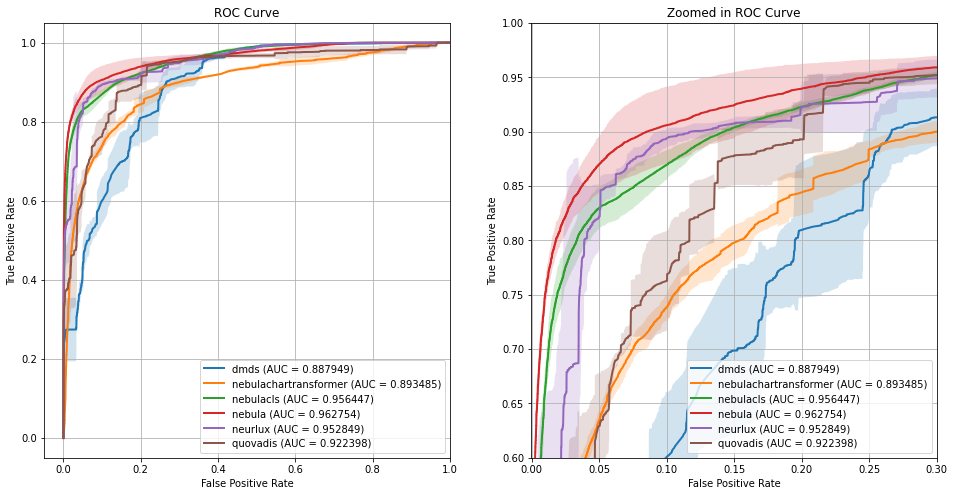

In [8]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

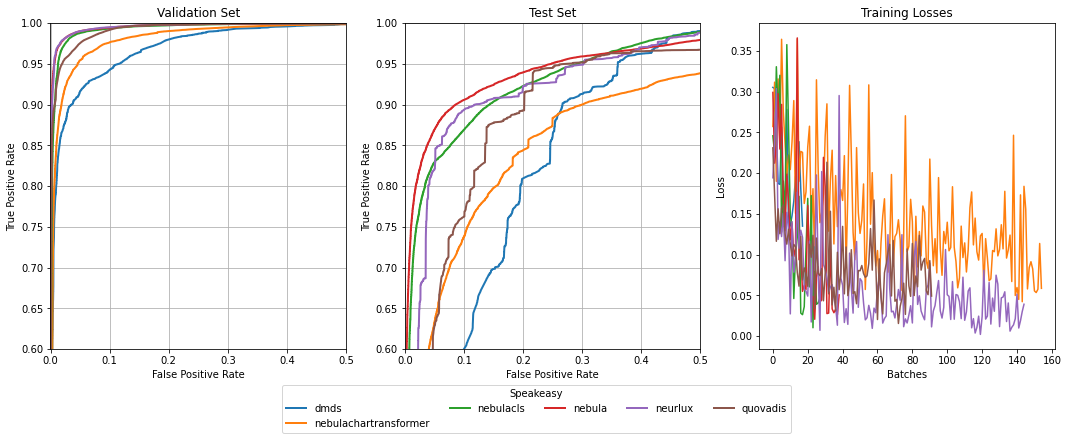

In [9]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 200
n = 50
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')

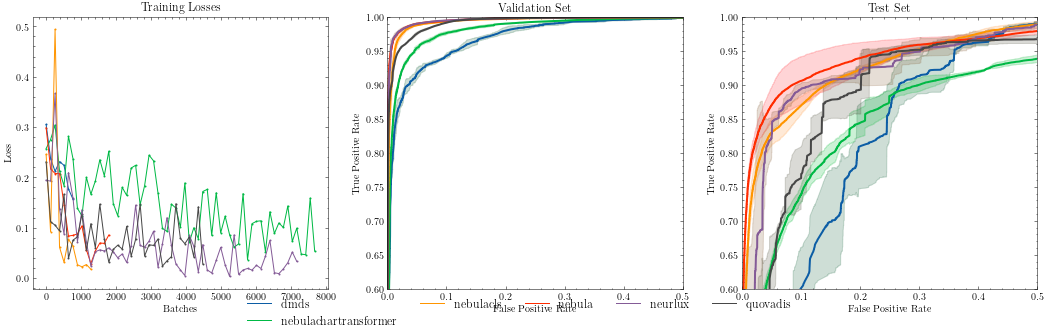

In [10]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])#,'no-latex'])

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], tprs_std_val[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], tprs_std_test[key], model_name=key, ax=axs[2], ylim=YLIM, xlim=XLIM)

axs[1].set_title("Validation Set")
axs[2].set_title("Test Set")
[ax.set_ylabel("True Positive Rate") for ax in axs[1:3]]
[ax.set_xlabel("False Positive Rate") for ax in axs[1:3]]

start = 200
n = 128
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]
    # account x for sampling rate n
    axs[0].plot(np.arange(len(loss_mean))*n, loss_mean, label=key)
    axs[0].scatter(np.arange(len(loss_mean))*n, loss_mean, s=1)
axs[0].set_xlabel("Batches")
# set xticklabels to account for sampling rate n
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.01), fontsize=12)
# do legend as above, but with increased font size
#_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')

cv_dmds_limNone_r1763_t5 1058
cv_nebulachartransformer_limNone_r1763_t5 7935
cv_nebulacls_limNone_r1763_t5 1586
cv_nebula_limNone_r1763_t5 2116
cv_neurlux_limNone_r1763_t5 7406
cv_quovadis_limNone_r1763_t5 4761


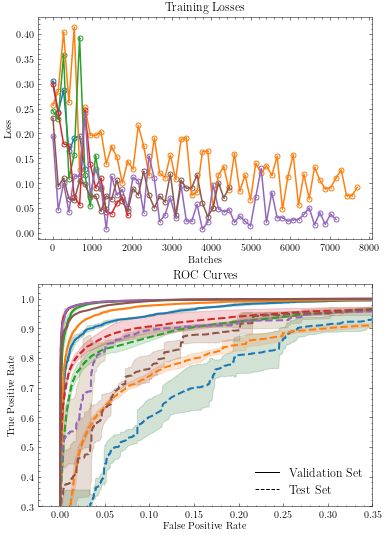

In [16]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])

# force reload function
from importlib import reload
import nebula.misc.plots as plots
reload(plots)
from nebula.misc.plots import plot_roc_curve


YLIM = [0.3, 1.05]
XLIM = [-0.025, 0.35]

colors = [
    "#1f77b4", # blue
    "#ff7f0e", # orange
    "#2ca02c", # green
    "#d62728", # red
    "#9467bd", # purple
    "#8c564b", # brown
]
fig, axs = plt.subplots(2, 1, figsize=(6, 9))
for i, key in enumerate(tprs_mean_val.keys()):
    if key == 0.01:
        continue
    plot_roc_curve(
        base_fpr_val, 
        tprs_mean_val[key], 
        tprs_std_val[key], 
        model_name=key, 
        ax=axs[1], 
        ylim=YLIM, 
        xlim=XLIM,
        color=colors[i]
    )
    plot_roc_curve(
        base_fpr_test,
        tprs_mean_test[key], 
        tprs_std_test[key], 
        model_name=key, 
        ax=axs[1], 
        ylim=YLIM, 
        xlim=XLIM, 
        linestyle="--",
        color=colors[i]
    )

axs[1].set_ylabel("True Positive Rate")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_title("ROC Curves")

start = 200
n = 135
for i, folder in enumerate(run_folders):
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    print(folder, len(np.load(train_losses)))
    loss_mean = np.load(train_losses)[start::n]    
    # account x for sampling rate n
    axs[0].plot(np.arange(len(loss_mean))*n, loss_mean, label=key, color=colors[i], linewidth=1.5)
    # scatter plot to show individual points with increased size
    axs[0].scatter(np.arange(len(loss_mean))*n, loss_mean, s=1, color=colors[i], linewidth=5)
axs[0].set_xlabel("Batches")
# set xticklabels to account for sampling rate n
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
# handles, labels = axs[1].get_legend_handles_labels()
# zhang, our, jindal, trizna, char, cls = handles[::2]
# fig.legend([zhang, trizna, jindal, our, char, cls], ['Zhang et al.', 'Trizna', 'Jindal et al.', 'Ours', "char", "cls"], loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05), fontsize=10)
# put a legend in ax[0] stating that "-" is validation set, and "--" is test set
handles = [plt.Line2D([0], [0], color='k', linestyle="-"), plt.Line2D([0], [0], color='k', linestyle="--")]
axs[1].legend(handles, ["Validation Set", "Test Set"], loc='lower right', ncol=1, fontsize=12)
# do legend as above, but with increased font size
_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')